In [2]:
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm

In [3]:
import json
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import rasterio as rio

In [6]:
from osgeo import gdal

In [7]:
from affine import Affine

## Stream network preprocessing

In [8]:
# step1 = gdal.Open('/media/x/data/paul/streams_all.map', gdal.GA_ReadOnly)
# GT_input = step1.GetGeoTransform()
# step2 = step1.GetRasterBand(1)
# img_as_array = step2.ReadAsArray()
# size1,size2=img_as_array.shape
# output=np.zeros(shape=(size1,size2))

# output = img_as_array.copy()
# output[output<7] = 0
# output[output>=7] = 1

# output = output.astype("int32")

# dst_crs='EPSG:3035'

# #transf = (583932.1992386435, 10.0, 0, 2223772.1491772938, 0, -10.0)
# afn = Affine.from_gdal(*GT_input)

# with rio.open(
#     "/media/x/data/paul/streams01.tif",
#     'w',
#     driver='GTiff',
#     height=output.shape[0],
#     width=output.shape[1],
#     count=1,
#     dtype=np.int32,
#     crs=dst_crs,
#     transform=afn,
# ) as dest_file:
#     dest_file.write(output, 1)
# dest_file.close()

## Catchments

In [9]:
#fpath = "/media/x/data/shape_collection/bkg.bund/vg250_01-01.utm32s.shape.ebenen/vg250_ebenen_0101/VG250_GEM.shp"
#fpath = "/media/x/data/kostra/GIS_KOSTRA-DWD-2010R_D0120/StatRR_KOSTRA-DWD-2010R_D0120.shp"
fpath = "/media/x/data/paul/downward_counterfactual.gpkg"

In [10]:
data = gpd.read_file(fpath)
data = data.to_crs(epsg=4326)

In [12]:
streams = gpd.read_file("/media/x/data/paul/streams_peuker.geojson")
streams = streams.to_crs(epsg=4326)
streams = streams[["geometry"]]

In [7]:
data.columns

Index(['sub_id', 'original_max', 'potential_max', 'which_potential',
       'which_original', 'flows_to', 'accu_at_outlet', 'time_to_next_outlet',
       'order', 'inflow_basins', 'area_km2', 'cum_upstream_area',
       'peak_area_ratio_original', 'peak_area_ratio_potential', 'giuh_ratio',
       'ratio>10', 'ratio_mean', 'ratio_median', 'Unnamed: 0', 'lag_time_mean',
       'lag_time_of_75percentile', 'lag_time_of_90percentile',
       'lag_time_of_95percentile', 'nr_cases', 'ratio_p_25', 'ratio_p_50',
       'ratio_p_75', 'ratio_p_90', 'ratio_p_95', 'highest_peak_event',
       'paper_name', 'geometry'],
      dtype='object')

In [8]:
# reduce size by selecting only specific attributes and rounding their values
attrsselect = ["peak_area_ratio_original", "peak_area_ratio_potential", "paper_name"]
data2 = data[attrsselect+["geometry"]]
data2[attrsselect] = data2[attrsselect].round(1)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
data2.peak_area_ratio_potential.max()

63.2

In [14]:
# Federal states
fpath = "/media/x/data/shape_collection/bkg.bund/vg250_01-01.utm32s.shape.ebenen/vg250_ebenen_0101/VG250_LAN.shp"
states = gpd.read_file(fpath)

In [15]:
# define which states are lumped
clipdefs = {"nrw": ["Nordrhein-Westfalen"],
            "shh": ["Schleswig-Holstein","Hamburg"],
            "nsb": ["Niedersachsen", "Bremen"],
            "hes": ["Hessen"],
            "rlp": ["Rheinland-Pfalz"],
            "bwb": ["Baden-Württemberg"],
            "bay": ["Bayern"],
            "saa": ["Saarland"],
            "bbr": ["Berlin", "Brandenburg"],
            "mbv": ["Mecklenburg-Vorpommern"],
            "sac": ["Sachsen"],
            "san": ["Sachsen-Anhalt"],
            "thu": ["Thüringen"],
           }

In [12]:
test = gpd.sjoin(data2,states[states.GEN=="Saarland"].to_crs(epsg=4326))[attrsselect+["geometry"]]
test.shape

(169, 4)

(49.11895319654311, 49.71036262368685)

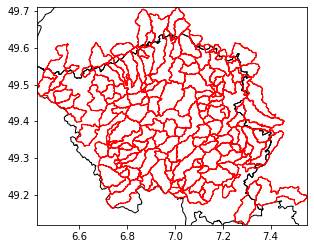

In [13]:
fig, ax = plt.subplots()
states.to_crs(epsg=4326).plot(ax=ax, edgecolor="black", facecolor="none")
test.plot(ax=ax, edgecolor="red", facecolor="none")
plt.xlim(test.bounds.minx.min(), test.bounds.maxx.max())
plt.ylim(test.bounds.miny.min(), test.bounds.maxy.max())

In [14]:
# Clipping states from full dataset
# (actually not clipping, but checking for overlap)
clip = {}
#bufferdist = 10000
for key in clipdefs.keys():
    print(clipdefs[key])
    if len(clipdefs[key])==1:
        clip[key] = gpd.sjoin(data2,states[states.GEN==clipdefs[key][0]].to_crs(epsg=4326))[attrsselect+["geometry"]]
#        clip[key] = data2.clip(states[states.GEN==clipdefs[key][0]].buffer(bufferdist).to_crs(epsg=4326))
    else:
        ix = np.repeat(False, len(states))
        for j, item in enumerate(clipdefs[key]):
            ix = ix | (states.GEN==clipdefs[key][j]).to_numpy()
        clip[key] = gpd.sjoin(data2,states[ix].to_crs(epsg=4326))[attrsselect+["geometry"]]
#        clip[key] = data2.clip(states[ix].buffer(bufferdist).to_crs(epsg=4326))    

['Nordrhein-Westfalen']
['Schleswig-Holstein', 'Hamburg']
['Niedersachsen', 'Bremen']
['Hessen']
['Rheinland-Pfalz']
['Baden-Württemberg']
['Bayern']
['Saarland']
['Berlin', 'Brandenburg']
['Mecklenburg-Vorpommern']
['Sachsen']
['Sachsen-Anhalt']
['Thüringen']


In [18]:
# recursive function to crop geojson coordinate precision (reducing file size)
def _set_precision(coords, precision):
    result = []
    try:
        return round(coords, int(precision))
    except TypeError:
        for coord in coords:
            result.append(_set_precision(coord, precision))
    return result

In [16]:
# crop geojson coordinate precision (reducing file size), save as js objects
precision = 5
for key in clip.keys():
    print(key)
    tmp = clip[key].to_json()
    with open("tmp", "w") as f:
        f.write(tmp)
    with open("tmp", "r") as f:
        item = json.load(f)    
    item2 = item.copy()
    for i, feature in enumerate(item["features"]):
        coords = _set_precision(feature['geometry']['coordinates'], precision)
        item2["features"][i]["geometry"]["coordinates"] = coords 
    with open("docs/"+key+".js", "w") as f:
        f.write("%s = " % key)
        json.dump(item2, f)

nrw
shh
nsb
hes
rlp
bwb
bay
saa
bbr
mbv
sac
san
thu


## Clip stream network

In [21]:
# Clipping states from full dataset
# (actually not clipping, but checking for overlap)
clipstream = {}
#bufferdist = 10000
for key in clipdefs.keys():
    print(clipdefs[key])
    if len(clipdefs[key])==1:
        clipstream[key+"_streams"] = gpd.sjoin(streams,states[states.GEN==clipdefs[key][0]].to_crs(epsg=4326))[["geometry"]]
#        clip[key] = data2.clip(states[states.GEN==clipdefs[key][0]].buffer(bufferdist).to_crs(epsg=4326))
    else:
        ix = np.repeat(False, len(states))
        for j, item in enumerate(clipdefs[key]):
            ix = ix | (states.GEN==clipdefs[key][j]).to_numpy()
        clipstream[key+"_streams"] = gpd.sjoin(streams,states[ix].to_crs(epsg=4326))[["geometry"]]
#        clip[key] = data2.clip(states[ix].buffer(bufferdist).to_crs(epsg=4326))    

['Nordrhein-Westfalen']
['Schleswig-Holstein', 'Hamburg']
['Niedersachsen', 'Bremen']
['Hessen']
['Rheinland-Pfalz']
['Baden-Württemberg']
['Bayern']
['Saarland']
['Berlin', 'Brandenburg']
['Mecklenburg-Vorpommern']
['Sachsen']
['Sachsen-Anhalt']
['Thüringen']


In [23]:
# crop geojson coordinate precision (reducing file size), save as js objects
precision = 5
for key in clipstream.keys():
    print(key)
    tmp = clipstream[key].to_json()
    with open("tmp", "w") as f:
        f.write(tmp)
    with open("tmp", "r") as f:
        item = json.load(f)    
    item2 = item.copy()
    for i, feature in enumerate(item["features"]):
        coords = _set_precision(feature['geometry']['coordinates'], precision)
        item2["features"][i]["geometry"]["coordinates"] = coords 
    with open("docs/streams/"+key+".js", "w") as f:
        f.write("%s = " % key)
        json.dump(item2, f)

nrw_streams
shh_streams
nsb_streams
hes_streams
rlp_streams
bwb_streams
bay_streams
saa_streams
bbr_streams
mbv_streams
sac_streams
san_streams
thu_streams


# Other

In [ ]:
x_map=dataclip.centroid.x.mean()
y_map=dataclip.centroid.y.mean()
print(x_map,y_map)

<AxesSubplot:>

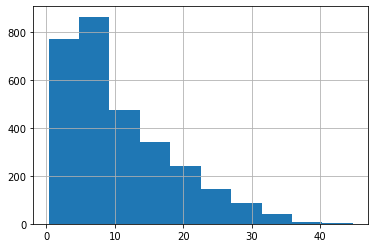

In [58]:
clip["nrw"]["peak_area_ratio_highest"].hist()

In [104]:
tmp = clip["nrw"]
tmp["ix"] = tmp.index
x_map=tmp.centroid.x.mean()
y_map=tmp.centroid.y.mean()

mymap = folium.Map(location=[y_map, x_map], zoom_start=8,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

myscale = (tmp['peak_area_ratio_highest'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
mymap.choropleth(
 geo_data=tmp,
 name='Choropleth',
 data=tmp,
 columns=['ix', 'peak_area_ratio_highest'],
 key_on="feature.properties.ix",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 fill_opacity=0.5,
 line_opacity=0.2,
)
#mymap

/tmp/ipykernel_4710/3747317201.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map=tmp.centroid.x.mean()
/tmp/ipykernel_4710/3747317201.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map=tmp.centroid.y.mean()
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [ ]:
#mymap.save("index.html")